In [1]:
import os
import sys
import random
import json
import collections
import re
from itertools import combinations

import pandas as pd
import numpy as np
import scipy
import statsmodels
from tqdm import trange, tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from lightgbm import LGBMClassifier

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline


pd.options.display.max_columns = 999

pd.options.display.max_rows = 100

sns.set()
plt.rcParams["figure.figsize"] = (10,7)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from sigmod_src.make_dataset import make_specs_dataset
from sigmod_src.preprocessing import preprocess_specs_dataset
from sigmod_src.pipeline import LGBMPipeline
from sigmod_src.utils import get_additional_labels, make_classes_df

In [4]:
LG_LABELS_PATH = '../data/raw/sigmod_large_labelled_dataset.csv'
SPECS_PATH = '../data/raw/2013_camera_specs/'

# Load labels df

In [5]:
labels_df = pd.read_csv(LG_LABELS_PATH)
labels_df.shape

(297651, 3)

# Load specs df

In [6]:
specs_dataset_src = make_specs_dataset(SPECS_PATH)

In [7]:
specs_df = preprocess_specs_dataset(specs_dataset_src)

Conflict, no matching items found for brand: tamron
Conflict, no matching items found for brand: tamron
Conflict, no matching items found for brand: shoot
Conflict, no matching items found for brand: cxin
Conflict, no matching items found for brand: shoot
Conflict, no matching items found for brand: shoot
Conflict, no matching items found for brand: shoot
Conflict, no matching items found for brand: shoot
Conflict, no matching items found for brand: shoot
Conflict, no matching items found for brand: neopine
Conflict, no matching items found for brand: godspeed
Conflict, no matching items found for brand: shoot
Conflict, no matching items found for brand: shoot
Conflict, no matching items found for brand: shoot
Conflict, no matching items found for brand: garmin
Conflict, no matching items found for brand: garmin
Conflict, no matching items found for brand: garmin
Conflict, no matching items found for brand: jvc
Conflict, no matching items found for brand: unknown
Conflict, no matching 

/notebooks/anton/sigmod/sigmod_src/preprocessing.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specs_df['brand'] = specs_df['brand'].apply(lambda brand: None if brand in cutoff_brands or not brand else brand)


Dropping 1068 camera bag specs
Dropping 1618 cctv specs
9
Warning, dropped 9 rows containing null page titles


/notebooks/anton/sigmod/sigmod_src/preprocessing.py:230: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print('Dropping', specs_df[specs_df.brand.isnull()][specs_df.page_title.str.contains('bag')][specs_df.page_title.str.contains('case')].shape[0], 'camera bag specs')


In [8]:
specs_df.index = specs_df.spec_id

In [9]:
sample = specs_df.sample(5)
sample[['page_title', 'page_title_stem', 'brand', 'model']].values

array([['canon ixus 500 hs comparison digital cameras australia',
        'canon ixus 500 hs comparison digit camera australia', 'canon',
        None],
       ['nikon coolpix s2800 digital vna570aa camerafarm australia',
        'nikon coolpix s2800 digit vna570aa camerafarm australia', 'nik',
        None],
       ['canon powershot sx510 hs 12 1mp digital jp version',
        'canon powershot sx510 hs 12 1mp digit jp version', 'canon',
        'sx510'],
       ['sony cyber shot dsc w50 6 0mp digital accessories',
        'soni cyber shot dsc w50 6 0mp digit accessori', 'sony',
        'dscw50'],
       ['canon eos rebel t5i slr digital kit w 18-55mm lens 18mp sd sdhc sdxc cardslot comparison net',
        'canon eo rebel t5i slr digit kit w 18-55mm len 18mp sd sdhc sdxc cardslot comparison net',
        'canon', 't5i']], dtype=object)

# Additional labels

In [10]:
additional_labels = get_additional_labels(labels_df, specs_df)

1274it [00:00, 5892.57it/s]
100%|██████████| 42/42 [01:41<00:00,  2.41s/it]


In [11]:
new_dups = additional_labels[additional_labels.label==1]
new_dups.head()

,left_spec_id,right_spec_id,label
0,www.ebay.com//45356,www.ebay.com//43231,1
1,www.ebay.com//46559,www.ebay.com//24325,1
2,www.ebay.com//53122,www.ebay.com//44489,1
3,www.ebay.com//53122,www.ebay.com//53584,1
4,www.ebay.com//53122,www.ebay.com//25103,1


In [12]:
new_dups.shape

(169657, 3)

In [13]:
sample = new_dups.sample(1)

print('Left\n', specs_df.loc[sample.left_spec_id].page_title_stem.values[0])
print('')
print('Right\n', specs_df.loc[sample.right_spec_id].page_title_stem.values[0])

Left
 canon eo rebel t3i 600d 18 0mp digit slr 18 55mm len

Right
 canon eo rebel t3i 600d 18 0mp digit slr kit w ef


In [14]:
new_non_dups = additional_labels[additional_labels.label==0]
new_non_dups.shape

(977021, 3)

In [15]:
sample = new_non_dups.sample(1)

print('Left\n', specs_df.loc[sample.left_spec_id].page_title_stem.values[0])
print('')
print('Right\n', specs_df.loc[sample.right_spec_id].page_title_stem.values[0])

Left
 nikon d50 6 1mp digit slr sigma apo 170 500mm telephoto len bundl

Right
 seal nikon coolpix s31 10 1mp digit


# Test pipeline

In [18]:
model = LGBMPipeline(specs_df, labels_df)

In [21]:
model.precompute()

1272it [00:00, 5628.80it/s]
100%|██████████| 43/43 [01:43<00:00,  2.40s/it]


In [22]:
%%time
train_left_spec_idx = model.specs_id_to_idx[labels_df['left_spec_id']]
train_right_spec_idx = model.specs_id_to_idx[labels_df['right_spec_id']]

train_X = make_X(model, train_left_spec_idx, train_right_spec_idx)

assert train_X.shape[0] == labels_df.shape[0]

NameError: name 'make_X' is not defined

In [119]:
model.train(precompute=False)

Precomputing
Making features
Making features for additional_labels
Fitting model


In [120]:
pred_train = model.clf.predict(model.train_X)

print('Train F1', f1_score(labels_df.label, pred_train))
print(classification_report(labels_df.label, pred_train))

Train F1 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    253612
           1       1.00      1.00      1.00     44039

    accuracy                           1.00    297651
   macro avg       1.00      1.00      1.00    297651
weighted avg       1.00      1.00      1.00    297651



Sanity check passed

# Feature importance

In [124]:
import shap

In [125]:
explainer = shap.TreeExplainer(model.clf)

In [126]:
shap_values = explainer.shap_values(model.train_X)

In [127]:
feature_names = model.feature_names

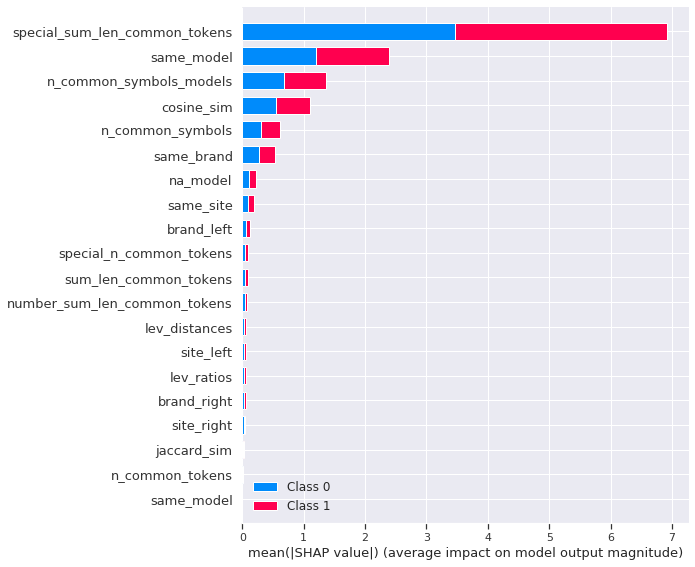

In [128]:
shap.summary_plot(shap_values, model.train_X, plot_type="bar", feature_names=feature_names)

# Submit

In [52]:
model.make_submission()

100%|██████████| 62/62 [17:07<00:00, 16.57s/it] 


In [53]:
submit_df = pd.read_csv('../data/submit/submit.csv')
submit_df.shape

(1059721, 2)

In [54]:
specs_df.index = specs_df.spec_id

In [64]:
row = submit_df.sample(1)

print('Left\n', specs_df.loc[row.left_spec_id].page_title.values[0])
print('')
print('Right\n', specs_df.loc[row.right_spec_id].page_title.values[0])

Left
 700tvl effio-e digital cctv 42 pieces ir-led security waterproof bullet digital waterproof cctv security waterproof bullet waterproof bullet alibaba com

Right
 high quality array led ir digital color ccd 700tvl cctv sony color ccd chip ir digital color ccd digital color cctv cctv 700tvl alibaba com


# CV

In [19]:
from tqdm.notebook import tqdm

In [20]:
def get_split(classes_df, labels_df, test_classes=5):
    classes = classes_df.class_.unique()
    test_classes = np.random.choice(classes, test_classes)
    
    test_spec_ids = classes_df[classes_df.class_.isin(test_classes)].spec_id
    
    test_label_mask = labels_df.left_spec_id.isin(test_spec_ids) | labels_df.right_spec_id.isin(test_spec_ids)
    
    test_idx = np.array(labels_df[test_label_mask].index)
    train_idx = np.array(labels_df[~test_label_mask].index)
    
    return train_idx, test_idx

def evaluate_submit(submit_df, test_labels_df):
    submit_df = submit_df.copy()
    submit_df['label'] = 1
    
    merged = test_labels_df.merge(submit_df, on=['left_spec_id', 'right_spec_id'], how='left', suffixes = ('_true', '_pred'))
    merged['label_pred'] = merged['label_pred'].fillna(0)
    
    tp = merged[(merged.label_true == 1) & (merged.label_pred == 1)]
    tn = merged[(merged.label_true == 0) & (merged.label_pred == 0)]
    
    fp = merged[(merged.label_true == 0) & (merged.label_pred == 1)]
    fn = merged[(merged.label_true == 1) & (merged.label_pred == 0)]
    
    precision = tp.shape[0]/(tp.shape[0]+fp.shape[0])
    recall = tp.shape[0]/(tp.shape[0]+fn.shape[0])
    
    f1 = 2 * (precision * recall)/(precision+recall)
    
    return f1, tp, tn, fp, fn

def cross_validate_pipeline(pipeline_class, specs_df, labels_df, clfs, n_folds=5, test_classes=5):
    # Obtain triangles from label and number them
    classes_df = make_classes_df(labels_df)
    folds = []
    submit_fpaths = []
    scores = []
    for i_fold in tqdm(range(n_folds)):
        print('Fold', i_fold)
        labels_train_idx, labels_test_idx = get_split(classes_df, labels_df, test_classes=test_classes)
        folds.append( (labels_train_idx, labels_test_idx) )
        
        train_labels = labels_df.iloc[labels_train_idx].copy()
        test_labels = labels_df.iloc[labels_test_idx].copy()
        
        submit_fpath = f'../data/interim/cv_submit_fold{i_fold}.csv'
        submit_fpaths.append(submit_fpath)
        
        model = pipeline_class(specs_df, train_labels, submit_fpath=submit_fpath)
        print('training model')
        model.train(clfs=clfs)
        
        print('generating submit')
        model.make_submission()
        
        print('evaluating submit')
        f1score, _, _, _, _ = evaluate_submit(pd.read_csv(model.submit_fpath), test_labels)
        scores.append(f1score)
        print('Score', f1score)
    return folds, submit_fpaths, scores

In [21]:
clfs = [
    LGBMClassifier(sample_pos_weight=5.76, n_jobs=-1),
    LGBMClassifier(sample_pos_weight=5.76, n_estimators=500, n_jobs=-1),
    LGBMClassifier(sample_pos_weight=5.76, learning_rate=0.01, n_jobs=-1),
    LGBMClassifier(sample_pos_weight=5.76, learning_rate=0.01, n_estimators=500, n_jobs=-1),
    
]

In [ ]:
# np.random.seed(42)
np.random.seed(None)
folds, submit_fpaths, scores = cross_validate_pipeline(LGBMPipeline, specs_df, labels_df, clfs, n_folds=3)

In [23]:
scores

[0.43317311141401826, 0.5178181818181818, 0.6896355353075171]

In [24]:
np.mean(scores)

0.5468756095132391

## Test evaluation scheme

In [25]:

    
    
test_labels_df = labels_df.iloc[folds[0][1]]
submit_df = pd.read_csv(submit_fpaths[0])

score, tp, tn, fp, fn = evaluate_submit(submit_df, test_labels_df)
score

0.43317311141401826

Test one true positive

In [26]:
tp.head()

,left_spec_id,right_spec_id,label_true,label_pred
7,www.ebay.com//44635,www.ebay.com//46524,1,1.0
88,www.ebay.com//25039,www.ebay.com//42055,1,1.0
162,www.ebay.com//43213,www.ebay.com//55623,1,1.0
279,www.ebay.com//42307,www.ebay.com//54400,1,1.0
294,www.ebay.com//43543,www.ebay.com//44044,1,1.0


In [27]:
test_labels_df[test_labels_df.label == 1][test_labels_df.left_spec_id == 'www.ebay.com//24206']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,left_spec_id,right_spec_id,label


In [28]:
submit_df[(submit_df.left_spec_id == 'www.ebay.com//24206') & (submit_df.right_spec_id == 'www.priceme.co.nz//54')]

,left_spec_id,right_spec_id


Pass

Check one tn

In [29]:
tn.head()

,left_spec_id,right_spec_id,label_true,label_pred
0,www.ebay.com//24817,www.ebay.com//58782,0,0.0
1,www.ebay.com//43019,www.ebay.com//58782,0,0.0
2,www.ebay.com//42055,www.ebay.com//54403,0,0.0
3,www.ebay.com//42039,www.ebay.com//43213,0,0.0
4,www.ebay.com//42196,www.ebay.com//58588,0,0.0


In [30]:
test_labels_df[test_labels_df.label == 0][test_labels_df.left_spec_id == 'www.ebay.com//42074'][test_labels_df.right_spec_id == 'www.ebay.com//47107']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,left_spec_id,right_spec_id,label


In [31]:
submit_df[submit_df.left_spec_id == 'www.ebay.com//42074'][submit_df.right_spec_id == 'www.ebay.com//47107']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,left_spec_id,right_spec_id


Pass

Check one fp

In [ ]:
fp.head()

In [ ]:
test_labels_df[test_labels_df.label == 0][test_labels_df.left_spec_id == 'www.ebay.com//42074'][test_labels_df.right_spec_id == 'www.ebay.com//54040']

In [ ]:
submit_df[submit_df.left_spec_id == 'www.ebay.com//42074'][submit_df.right_spec_id == 'www.ebay.com//54040']

Pass

Check one fn

In [ ]:
fn.head()

In [ ]:
test_labels_df[test_labels_df.label == 1][test_labels_df.left_spec_id == 'www.ebay.com//54040'][test_labels_df.right_spec_id == 'www.ebay.com//54457']

In [ ]:
submit_df[submit_df.left_spec_id == 'www.ebay.com//54040'][submit_df.right_spec_id == 'www.ebay.com//54457']

pass